# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
!ls

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [2]:
import sklearn

if float(sklearn.__version__[:4]) < 0.20 : 
    print("PLEASE RESTART NOTEBOOK AFTER THIS INSTALLATION")
    !pip install scikit_learn -U
    

import sklearn
print(sklearn.__version__)

0.23.1


In [3]:
# import libraries

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pprint

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

try:
    from sklearn.model_selection import GridSearchCV
except : 
    print("old version sklearn detected..")
    from sklearn.grid_search import GridSearchCV


from sqlalchemy import create_engine

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.corpus import stopwords

nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\CR5820\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CR5820\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CR5820\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CR5820\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\CR5820\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')

df = pd.read_sql_table(table_name="InsertTableName", con=engine)

X = df["message"]
y = df.drop(columns=["id", "message", "original", "genre"], axis=1)

# drop the one category without any occurrences
y.drop(columns=["child_alone"], inplace = True)

X.head()

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # replace all urls with a placeholder text
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, "urlplaceholder", text)
    
    # remove numbers
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
   
    stop_words = stopwords.words("english")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    # lemmatize and remove stop words
    clean_tokens = []
    for tok in tokens:
        if tok not in stop_words :
            clean_tok = lemmatizer.lemmatize(tok).strip() 
            clean_tokens.append(clean_tok)
    
    return clean_tokens    

In [6]:
# df = X.to_frame()
# df["len"] = df["message"].str.len()

# df.dropna(inplace=True)

# df.head()

In [7]:
# df.describe()

In [8]:
# sns.distplot(df["len"], bins=1000)

# plt.xlim(0,1000)

# df.shape

In [9]:
import string



def clean_text(text) :
    
    text = text.replace("\n", " ").replace("\r", " ")
    
    # replace punctuation with spaces
    t = str.maketrans(' ', ' ', string.punctuation)
    text = text.translate(t)
    
    # replace single auote with empty char
    t = str.maketrans(dict.fromkeys("'`", ""))
    text = text.translate(t)
    
    # replace all urls with a placeholder text
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, "urlplaceholder", text)
    
    return text


def reg_tokenize(text):     
    
    text = clean_text(text)

    # break into list of words
    WORD = re.compile(r'\w+')    
    words = WORD.findall(text)
    
    #pass through lemmatizer or stemmer
    stop_words = stopwords.words("english")

    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    lancaster = LancasterStemmer()
    clean_tokens = []
    for tok in words :
        if tok not in stop_words :
#             clean_tok = lemmatizer.lemmatize(tok)
#             clean_tok = porter.stem(tok)
            clean_tok = lancaster.stem(tok)
            clean_tokens.append(clean_tok)
    
    return clean_tokens

In [10]:
#benchmarking tokenizer
import time

messages = list(X)

for num_messages in [10, 100, 1000, 10000]:
    
    t1 = time.time()
    
    toks = []
    [toks.append(tokenize(n)) for n in messages[:num_messages]]
    
    t2 = time.time()
    
    print('num messages = ', num_messages, ", time = %.3f"%(t2-t1))
    

all_toks = [item for sublist in toks for item in sublist] 
print(len(all_toks))
print("unique", len(set(all_toks)))

num messages =  10 , time = 1.162
num messages =  100 , time = 0.043
num messages =  1000 , time = 0.488
num messages =  10000 , time = 4.597
81900
unique 9133


In [11]:
#benchmarking reg_tokenize
import time

messages = list(X)

for num_messages in [10, 100, 1000, 10000]:
    
    t1 = time.time()
    
    toks = []
    [toks.append(reg_tokenize(n)) for n in messages[:num_messages]]
    
    t2 = time.time()
    print('num messages = ', num_messages, ", time = %.3f"%(t2-t1))
    
all_toks = [item for sublist in toks for item in sublist]

print(len(all_toks))
print("unique", len(set(all_toks)))

num messages =  10 , time = 0.010
num messages =  100 , time = 0.073
num messages =  1000 , time = 0.620
num messages =  10000 , time = 5.268
98276
unique 8195


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [12]:
# need to add the filtering of the "message" column only here I guess ...

# pipe = Pipeline([
#     ('features', FeatureUnion([
#         ('text_pipeline', Pipeline([
#             ('col', ColumnSelector(col="message")),
#             ('vect', CountVectorizer(tokenizer=tokenize)),
#             ('tdidf', TfidfTransformer()),
#         ])),
# #         ('starting_verb', StartingVerbExtractor())
#     ])),
#     ('clf', MultiOutputClassifier(RandomForestClassifier()))
# ])

pipe = Pipeline([
#     ('vect', CountVectorizer(tokenizer=tokenize)),
#     ('vect', CountVectorizer(tokenizer=reg_tokenize)),
    ('vect_tdidf', TfidfVectorizer(tokenizer=reg_tokenize)),
#     ('tdidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=0)))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
# split and fit data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
%%time
pipe.fit(X_train, y_train)

Wall time: 32.1 s


Pipeline(steps=[('vect_tdidf',
                 TfidfVectorizer(tokenizer=<function reg_tokenize at 0x000001E82F1678B0>)),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                                        n_jobs=-1)))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
# predict on test data
def evaluate(model, X_test, y_test):
    """Predicts and prints scores of model.
    """
    
    cols = y_test.columns
    y_pred = model.predict(X_test)
    
    print('Accuracy = %.3f' % accuracy_score(y_test, y_pred))

    
    report = classification_report(y_test, y_pred, target_names=cols,)
    print(report)
    
    if float(sklearn.__version__[:4]) >= 0.20 :
        
        output_dict = classification_report(y_test, y_pred, target_names=cols, output_dict=True)
        df = pd.DataFrame.from_dict(output_dict, orient="index")
        
        # plot        
        plt.figure(figsize=(6,10))
        sns.barplot(df["f1-score"].sort_values(), df["f1-score"].sort_values().index)
        
        return df
    
    else :
        
        print("sklearn version is old.")
        output = pd.Series()
        
        for i, c in enumerate(cols) : 
            score = f1_score(y_test[c], y_pred.transpose()[i]) 
            output[c] = score
        return output

Accuracy = 0.254
                        precision    recall  f1-score   support

               related       0.84      0.92      0.88      4970
               request       0.79      0.43      0.55      1135
                 offer       0.00      0.00      0.00        23
           aid_related       0.72      0.60      0.65      2650
          medical_help       0.71      0.10      0.18       522
      medical_products       0.78      0.09      0.15       341
     search_and_rescue       0.73      0.06      0.11       186
              security       0.33      0.01      0.02       105
              military       0.58      0.09      0.16       210
                 water       0.79      0.25      0.38       387
                  food       0.80      0.49      0.61       698
               shelter       0.83      0.31      0.45       580
              clothing       0.62      0.05      0.09        99
                 money       0.67      0.03      0.06       134
        missing_people

C:\Users\CR5820\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CR5820\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CR5820\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CR5820\Anaconda3\lib\site-packages\seaborn\_decorat

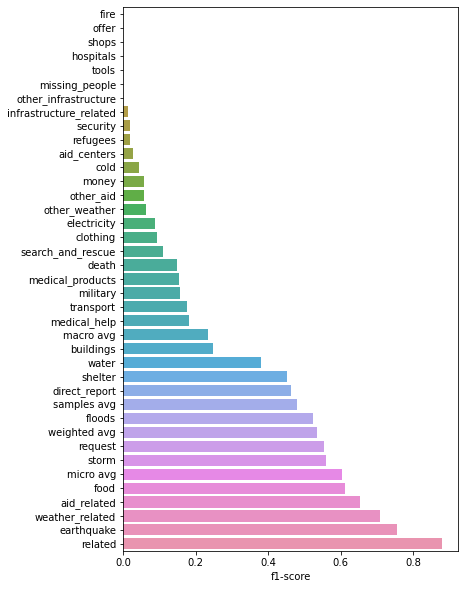

In [17]:
score_df = evaluate(pipe, X_test, y_test)

### 6. Improve your model
Use grid search to find better parameters. 

In [18]:
pprint.pprint(pipe.get_params(), indent=2)

{ 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                       n_jobs=-1)),
  'clf__estimator': RandomForestClassifier(n_estimators=10, n_jobs=-1),
  'clf__estimator__bootstrap': True,
  'clf__estimator__ccp_alpha': 0.0,
  'clf__estimator__class_weight': None,
  'clf__estimator__criterion': 'gini',
  'clf__estimator__max_depth': None,
  'clf__estimator__max_features': 'auto',
  'clf__estimator__max_leaf_nodes': None,
  'clf__estimator__max_samples': None,
  'clf__estimator__min_impurity_decrease': 0.0,
  'clf__estimator__min_impurity_split': None,
  'clf__estimator__min_samples_leaf': 1,
  'clf__estimator__min_samples_split': 2,
  'clf__estimator__min_weight_fraction_leaf': 0.0,
  'clf__estimator__n_estimators': 10,
  'clf__estimator__n_jobs': -1,
  'clf__estimator__oob_score': False,
  'clf__estimator__random_state': None,
  'clf__estimator__verbose': 0,
  'clf__estimator__warm_start': False,
  'clf__n_jobs': Non

In [38]:
%%time

parameters = {
#     'vect__ngram_range': ((1, 1), (1, 2)),
#     'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (None, 5000, 10000),
     "clf__estimator__n_estimators" : (10,20,50,100),
}

# We define 3 cross validation folds.
# In principle the more the better, but it takes more time too.

cv = GridSearchCV(pipe, param_grid=parameters, verbose=100, cv = 3)

cv.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf__estimator__n_estimators=10 .................................
[CV] ..... clf__estimator__n_estimators=10, score=0.244, total=  34.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.8s remaining:    0.0s
[CV] clf__estimator__n_estimators=10 .................................
[CV] ..... clf__estimator__n_estimators=10, score=0.240, total=  24.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.8s remaining:    0.0s
[CV] clf__estimator__n_estimators=10 .................................
[CV] ..... clf__estimator__n_estimators=10, score=0.237, total=  25.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[CV] clf__estimator__n_estimators=20 .................................
[CV] ..... clf__estimator__n_estimators=20, score=0.256, total=  26.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect_tdidf',
                                        TfidfVectorizer(tokenizer=<function reg_tokenize at 0x000001E82F1678B0>)),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                                                               n_jobs=-1)))]),
             param_grid={'clf__estimator__n_estimators': (10, 20, 50, 100)},
             verbose=100)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [21]:
cv.best_params_

{'clf__estimator__n_estimators': 50}

Accuracy = 0.272
                        precision    recall  f1-score   support

               related       0.83      0.94      0.89      4970
               request       0.83      0.48      0.60      1135
                 offer       0.00      0.00      0.00        23
           aid_related       0.75      0.69      0.72      2650
          medical_help       0.75      0.10      0.17       522
      medical_products       0.77      0.06      0.11       341
     search_and_rescue       0.75      0.05      0.09       186
              security       0.40      0.02      0.04       105
              military       0.69      0.05      0.10       210
                 water       0.85      0.43      0.57       387
                  food       0.84      0.59      0.69       698
               shelter       0.82      0.37      0.50       580
              clothing       0.80      0.12      0.21        99
                 money       1.00      0.01      0.03       134
        missing_people

C:\Users\CR5820\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CR5820\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CR5820\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CR5820\Anaconda3\lib\site-packages\seaborn\_decorat

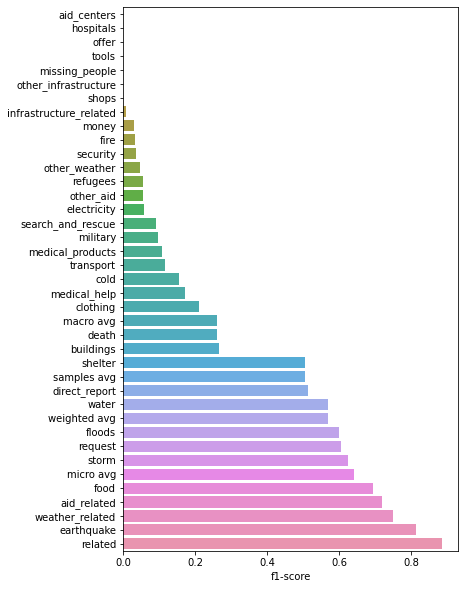

In [22]:
score_df = evaluate(cv, X_test, y_test)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [23]:
# !pip install xgboost, 
# not possible in udacity workspace :(

In [35]:
from xgboost import XGBClassifier

# subsample controls the ratio of the randomly selected training samples before growing the tree.
# It ranges between 0 and 1. Higher values tend to cause overfitting. 
# colsample_bytree denotes the fraction of columns 
# to be randomly sampled for each tree.
# n_estimators controls the number of trees to be constructed
# during the classification process. We will optimize that parameter.


xgbclf = XGBClassifier(
    n_estimators=50, 
    n_jobs=-1, 
    random_state=42,
    seed=2,
    colsample_bytree=0.6,
    subsample=0.7,
    eval_metric = "logloss", 
    use_label_encoder=False
)


pipe_xgb = Pipeline([
    ('vect_tdidf', TfidfVectorizer(tokenizer=reg_tokenize)),
    ('xgbclf', MultiOutputClassifier(xgbclf))
])

In [36]:
%%time 
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('vect_tdidf',
                 TfidfVectorizer(tokenizer=<function reg_tokenize at 0x000001E82F1678B0>)),
                ('xgbclf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=0.6,
                                                               eval_metric='logloss',
                                                               gamma=None,
                                                               gpu_id=None,
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                  

Accuracy = 0.283
                        precision    recall  f1-score   support

               related       0.81      0.96      0.88      4970
               request       0.78      0.54      0.64      1135
                 offer       0.00      0.00      0.00        23
           aid_related       0.76      0.65      0.70      2650
          medical_help       0.64      0.29      0.40       522
      medical_products       0.66      0.30      0.41       341
     search_and_rescue       0.70      0.21      0.32       186
              security       0.46      0.06      0.10       105
              military       0.57      0.39      0.46       210
                 water       0.76      0.68      0.72       387
                  food       0.79      0.76      0.78       698
               shelter       0.75      0.58      0.66       580
              clothing       0.76      0.47      0.58        99
                 money       0.49      0.25      0.33       134
        missing_people

C:\Users\CR5820\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CR5820\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CR5820\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


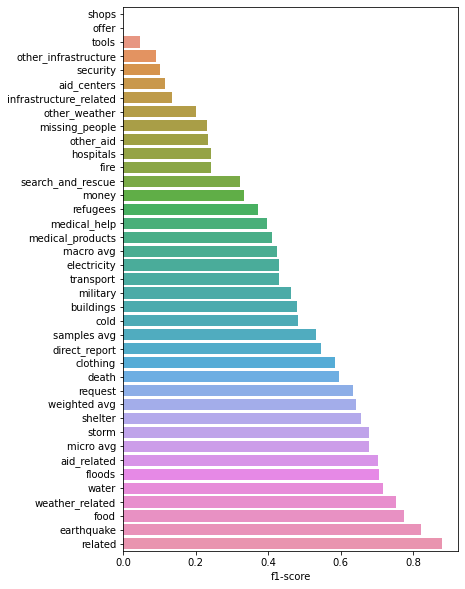

In [37]:
score_df = evaluate(pipe_xgb, X_test, y_test)

### 9. Export your model as a pickle file

In [ ]:
pickle.dump(pipe, open( model_filepath, "wb" ))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.